In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub, TUDataset
from torch_geometric.utils import to_networkx, scatter, to_dense_adj
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import networkx as nx
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from icecream import ic
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import add_self_loops, degree, to_dense_adj
from sklearn.metrics import jaccard_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


In [3]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [4]:
def compute_jaccard_similarity(edge_index, num_nodes):
    adj = to_dense_adj(edge_index, max_num_nodes=num_nodes).squeeze(0).numpy()
    jaccard_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                jaccard_matrix[i, j] = jaccard_score(adj[i], adj[j])
    return torch.from_numpy(jaccard_matrix).float()


dataset = KarateClub()
data = dataset[0]

target_jaccard = compute_jaccard_similarity(data.edge_index, data.num_nodes).to(device)


In [24]:
class SimpleGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SimpleGCNConv, self).__init__()
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        x = self.lin(x)
        row, col = edge_index
        out = torch.zeros(x.size(0), x.size(1)).to(x.device)
        row, col = edge_index
        for i, (src, tgt) in enumerate(zip(row, col)):
            out[tgt] += norm[i] * x[src]
        # for i in range(edge_index.size(1)):
        #    source_node = col[i]
        #    target_node = row[i]
        #    out[target_node] += norm[i] * x[source_node]
        return out


class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = SimpleGCNConv(in_channels, hidden_channels)
        self.conv2 = SimpleGCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [25]:
data = data.to(device)
edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)
ic(edge_index);

ic| edge_index: tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
                          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
                          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
                          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
                         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
                         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
                         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
                         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
                         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,  0,  1,  2,  3,  4,  5,
                          6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                         24, 2

In [26]:
data.x.shape, data.edge_index.shape, data.num_nodes
data.x.dtype

torch.float32

In [27]:
row, col = edge_index
ic(row, col)
deg = degree(index=col, num_nodes=data.x.size(0), dtype=data.x.dtype)
ic(deg, deg.shape);

ic| row: tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
                  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
                  3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
                  7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
                 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
                 21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
                 27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
                 31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
                 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,  0,  1,  2,  3,  4,  5,
                  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], device='mps:0')
    col: tensor([ 1,  2,  3,  4,  5,

In [28]:
deg_inv_sqrt = deg.pow(-0.5)
ic(deg_inv_sqrt)
deg_inv_sqrt[deg_inv_sqrt == float("inf")] = 0
ic(deg_inv_sqrt);

ic| deg_inv_sqrt: tensor([0.2425, 0.3162, 0.3015, 0.3780, 0.5000, 0.4472, 0.4472, 0.4472, 0.4082,
                          0.5774, 0.5000, 0.7071, 0.5774, 0.4082, 0.5774, 0.5774, 0.5774, 0.5774,
                          0.5774, 0.5000, 0.5774, 0.5774, 0.5774, 0.4082, 0.5000, 0.5000, 0.5774,
                          0.4472, 0.5000, 0.4472, 0.4472, 0.3780, 0.2774, 0.2357],
                         device='mps:0')
ic| deg_inv_sqrt: tensor([0.2425, 0.3162, 0.3015, 0.3780, 0.5000, 0.4472, 0.4472, 0.4472, 0.4082,
                          0.5774, 0.5000, 0.7071, 0.5774, 0.4082, 0.5774, 0.5774, 0.5774, 0.5774,
                          0.5774, 0.5000, 0.5774, 0.5774, 0.5774, 0.4082, 0.5000, 0.5000, 0.5774,
                          0.4472, 0.5000, 0.4472, 0.4472, 0.3780, 0.2774, 0.2357],
                         device='mps:0')


In [29]:
# multiply row with its corresponding value in deg_inv_sqrt * col with its corresponding value in deg_inv_sqrt
norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
ic(deg_inv_sqrt[row])
ic(norm);

ic| deg_inv_sqrt[row]: tensor([0.2425, 0.2425, 0.2425, 0.2425, 0.2425, 0.2425, 0.2425, 0.2425, 0.2425,
                               0.2425, 0.2425, 0.2425, 0.2425, 0.2425, 0.2425, 0.2425, 0.3162, 0.3162,
                               0.3162, 0.3162, 0.3162, 0.3162, 0.3162, 0.3162, 0.3162, 0.3015, 0.3015,
                               0.3015, 0.3015, 0.3015, 0.3015, 0.3015, 0.3015, 0.3015, 0.3015, 0.3780,
                               0.3780, 0.3780, 0.3780, 0.3780, 0.3780, 0.5000, 0.5000, 0.5000, 0.4472,
                               0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.4472, 0.4472,
                               0.4472, 0.4472, 0.4082, 0.4082, 0.4082, 0.4082, 0.4082, 0.5774, 0.5774,
                               0.5000, 0.5000, 0.5000, 0.7071, 0.5774, 0.5774, 0.4082, 0.4082, 0.4082,
                               0.4082, 0.4082, 0.5774, 0.5774, 0.5774, 0.5774, 0.5774, 0.5774, 0.5774,
                               0.5774, 0.5774, 0.5774, 0.5000, 0.5000, 0.

In [30]:
in_channels = dataset.num_features
out_channels = 16
lin = nn.Linear(in_channels, out_channels).to(device)
x = lin(data.x)
ic(x.shape)

ic| x.shape: torch.Size([34, 16])


torch.Size([34, 16])

In [39]:
# aggregate the x values of each neighbout node
# x is a linear transformation of the original x
row, col = edge_index
out = torch.zeros(x.size(0), x.size(1)).to(x.device)
ic(out.shape)

for i, (src, tgt) in enumerate(zip(row, col)):
    out[tgt] += norm[i] * x[src]
out

ic| out.shape: torch.Size([34, 16])


tensor([[-1.7114e-01,  3.4069e-01, -1.2962e-01,  3.5315e-01,  5.9452e-02,
         -1.9096e-01, -1.2778e-01, -1.5971e-01, -2.9054e-01,  2.2277e-01,
         -2.7686e-01,  6.3024e-02, -6.0149e-02,  2.1226e-02,  7.6139e-02,
         -8.0071e-02],
        [-9.9992e-02,  2.5420e-01, -1.7767e-01,  2.8736e-01,  5.8850e-02,
         -8.8369e-02, -1.1038e-01, -1.2249e-01, -2.3443e-01,  1.7898e-01,
         -1.8181e-01,  4.2769e-02, -4.4481e-02, -2.1806e-02,  3.8796e-02,
         -5.8232e-02],
        [-1.6408e-01,  2.7988e-01, -1.1740e-01,  2.8921e-01,  1.1311e-01,
         -1.0562e-01, -1.2279e-01, -1.7654e-01, -1.9642e-01,  1.9108e-01,
         -1.9135e-01,  9.4801e-02, -1.3687e-01, -7.3531e-02,  3.1182e-02,
         -1.3770e-01],
        [-1.5076e-01,  1.4448e-01, -7.0201e-02,  1.8738e-01,  9.1038e-02,
         -6.4527e-02, -6.1268e-02, -1.3271e-01, -1.0354e-01,  2.1670e-01,
         -1.2522e-01,  4.3139e-02, -1.3426e-02, -1.9236e-02,  2.5977e-02,
         -5.5211e-02],
        [-1.0555e-01

True

In [34]:
model = GCN(dataset.num_node_features, 16, data.num_nodes).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.mse_loss(out, target_jaccard)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")

model.eval()
embeddings = model(data.x, data.edge_index).cpu().detach().numpy()


Epoch: 000, Loss: 0.0705
Epoch: 020, Loss: 0.0343
Epoch: 040, Loss: 0.0279
Epoch: 060, Loss: 0.0243
Epoch: 080, Loss: 0.0228
Epoch: 100, Loss: 0.0223
Epoch: 120, Loss: 0.0199
Epoch: 140, Loss: 0.0209
Epoch: 160, Loss: 0.0172
Epoch: 180, Loss: 0.0204


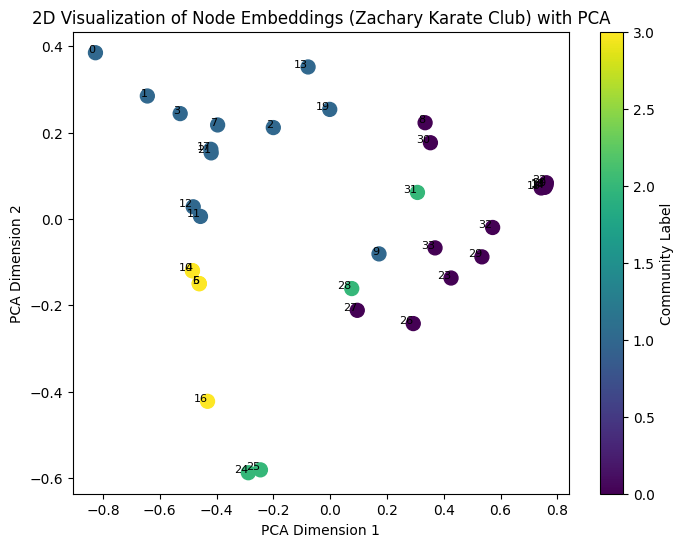

In [35]:
pca = PCA(n_components=2)
Z_2d = pca.fit_transform(embeddings)
labels = data.y.cpu().numpy()
num_nodes = data.num_nodes
# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club) with PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()